## Overview
#### This notebook is the first of many that will conduct exploratory data analysis on different types of features. Here, I evaluate a variety of basic demographic factors. Age is the factor most commonly utilized in other CDI prediction models

## Notebook Sections
#### a) Import Libraries, Data, and Setup BigQuery Authorization 
#### b) Define Functions for EDA
    Similar functions will be utilized across all notebooks. Key EDA functions include:
    1) Histograms for evaluating continuous variables,
    2) Categorical stats and logistic regression functions for evaluating and validating features
    3) Cubic spline creation function for transforming numeric variables
#### c) Feature generation and selection
##### Demographic features explored:
    age
    gender
    insurance
    language
    ethnicity
    marital status 
##### Continuous variables inclusion criteria (age) :
    1) Statistically significant in univariate logistic regression at p-value <= 0.05
    2) Transformed via cubic spline interpolation
##### Nominal and Binary variables inclusion criteria (all others):
    1) Statistically significant in univariate logistic regression at p-value <= 0.05, including after accounting for age and other significant demographic predictors    
    2) Must also have 500+ total cases within each option for a variable. If an option does not meet this cutoff, it is combined with another feature based on similarity in description or CDI rate in training data

## Output 
    1) Updated ICU admits train/test dataframes (ages below 20 are recategorized to be excluded from further analysis)
    2) Demographics train/test dataframes to contain all significant demographics features after EDA
## Results Summary     

    Age: After transforming via cubic splines, all age predictors remain statistically significant
    
    Gender: Not statistically significant
    
    Insurance: Self Pay, Private or Government insurance found to have significantly lower rates of CDI compared to Medicare and Medicaid insurance, even after accounting for age
    
    Ethnicity: grouped into broader categories for analysis, but none found to be statistically significant
    
    Language: English speakers specifically have significantly lower rates of observed CDI compared to others
    
    Marital Status: Those who are divorced in particular have significantly lower rates of observed CDI compared to others

## A) Import libraries and data, and set up Big Query Authorization

In [1]:
from google.cloud import bigquery
from google_auth_oauthlib import flow

client = bigquery.Client()

project = 'mimiciii-249117'

In [3]:
# Import libraries for analysis within notebook
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices, dmatrix
from scipy import stats
from scipy.stats import kurtosis, kurtosistest, skew, skewtest
import statsmodels.discrete.discrete_model as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score

In [3]:
launch_browser = True

In [4]:
appflow = flow.InstalledAppFlow.from_client_secrets_file(
    'C:/Users/fuzzyman27/BigQuery/client_secrets.json',
    scopes=['https://www.googleapis.com/auth/bigquery'])

if launch_browser:
    appflow.run_local_server()
else:
    appflow.run_console()

credentials = appflow.credentials

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=579414793473-ak30u31klvdecqfv6kg8542ofeeegm18.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=9YxJBjivbyrsnlu7KJAeQy7ZKBcBKQ&access_type=offline&code_challenge=7f8thvvkNMKeJDgMo67dQiioi94r6TphwMtuzbwOhGU&code_challenge_method=S256


In [5]:
client = bigquery.Client(project=project, credentials=credentials)

In [6]:
# Define small function to run SQL queries and return a dataframe
def run_query(query):
    return client.query(query).to_dataframe()

#### Import ICU Train and Test DataFrames from 2nd Notebook

In [7]:
icu_admits_train = pd.read_csv("../Data/2 - ICU Admits Train.csv").drop(columns = "Unnamed: 0")
icu_admits_test = pd.read_csv("../Data/2 - ICU Admits Test.csv").drop(columns = "Unnamed: 0")

## B) Define functions

In [8]:
# Define function that returns difference in days of two dates
def date_diff(first_date, second_date):
    diff = (first_date - np.timedelta64(0,'s')) - (second_date - np.timedelta64(0,'s'))
    return ((diff.components.days) + (diff.components.hours/24) + (diff.components.minutes/(60*24)))

#### Create functions for plotting

In [9]:
# Create function to plot histogram and associated statistics from a series
# Includes mean, standard deviation, middle 50% bounds, and scipy statistical tests for skewness and kurtosis
def plot_one_hist(series = None, color = None, xlabel = "", ylabel = "", title = ""):
    fig, ax = plt.subplots(figsize = (15, 10))
    sns.distplot(series, kde = False, color = color)
    stats = series.describe()
    count = int(stats["count"])
    mean = stats["mean"]
    std = stats["std"]
    mid = stats["50%"]
    lower = stats["25%"]
    upper = stats["75%"]
    plt.title(title + "\n"  + "n = " + str(count), fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    ax.set_ylabel(ylabel, fontsize = 20)
    ax.set_xlabel(xlabel, fontsize = 20)  
    plt.axvline(x = mean, label = "mean " + str(round(mean, 3)), linewidth = 3, color = "green")
    plt.axvline(x = mean + std, label = "+/- 1 std = " + str(round(std, 3)), linewidth = 3, color = "red")
    plt.axvline(x = mean - std, linewidth = 3, color = "red")
    plt.axvline(x = lower, linewidth = 3, label = "middle 50%: \n" + str(round(lower,3)) + " / " + str(round(upper,3)), color = "orange")
    plt.axvline(x = upper, linewidth = 3, color = "orange")
    plt.legend(fontsize = 15)
    print("Kurtosis / test stat / p-value " + 
          str(round(kurtosis(series), 3)) + " / " + 
          str(round(kurtosistest(series)[0], 3)) + " / " + 
          str(kurtosistest(series)[1]))
    print("Skew statistic / p-value: " + 
          str(round(skew(series), 3)) + " / " + 
          str(skewtest(series)[1]))   

In [10]:
def plot_two_hist(series1, series2, xlabel = "", ylabel = "", title = ""):
    fig, ax = plt.subplots(figsize = (15, 10))
    
    sns.distplot(series1, kde = False)
    sns.distplot(series2, kde = False)
    
    stats1 = series1.describe()
    stats2 = series2.describe()
    
    count1 = int(stats1["count"])
    count2 = int(stats2["count"])
    
    plt.title(title, fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    ax.set_ylabel(ylabel, fontsize = 20)
    ax.set_xlabel(xlabel, fontsize = 20)  
    print("Two-sample Kolmogorov-Smirnov Test:")
    print("Statistic: " + str(stats.ks_2samp(series1, series2)[0]))
    print("P-Value: " + str(stats.ks_2samp(series1, series2)[1]))
    

#### Create functions and univariate model implementation to evaluate feature significance

In [30]:
# Runs univariate logistic regression in stats-models and outputs results
def uni_log(var_list, df, categorical, return_model = False):
    df2 = pd.DataFrame()
    if(categorical == True):
        dummies = pd.get_dummies(df[var_list], prefix = var_list)
        columns = dummies.columns.to_list()[1:]
        df2 = pd.merge(df, pd.get_dummies(df[var_list], prefix = var_list), left_index = True, right_index = True)
    else:
        df2 = df
        columns = var_list    
    y = df2[df2["overall_exclude"] == False]["cdi_dx_include"]
    x = df2[df2["overall_exclude"] == False][columns]
    logit = sm.Logit(y, x)
    result = logit.fit()

    print("Summary Stats:")
    print(result.summary())
    print("Odds Ratio")
    print(np.exp(result.params))
    if return_model == True:
        return result

In [12]:
# For categorical variables, outputs, counts and CDI rates, and calls univariate logistic regression function
def categorical_stats(var_name, df, binary, skip_model = False):
    print("Counts:")
    print(df[df["overall_exclude"]==False][var_name].value_counts())
    print()
    print("Mean CDI Rate:")
    print(df[df["overall_exclude"]==False].groupby(by=var_name)["cdi_dx_include"].mean())
    print()
    if(skip_model == False):
        if(binary == True):
            uni_log(var_name, df, categorical = False)
        else:
            uni_log(var_name, df, categorical = True)        

In [13]:
# Takes continuous variable and cutoff list and returns dataframe with that variable binned by the cutoffs
def bin_variable(df, cutoff_list, var_name):
    var_buckets = pd.DataFrame(data = pd.cut(df[var_name], cutoff_list)).rename(columns = {var_name : var_name + "_bucket"})
    return pd.merge(df, var_buckets, left_index = True, right_index = True)

##### Create function to enable cubic spline implementation from list of knot points

In [14]:
def create_knot_df(df, var_name, knot_list):
    knot_string = str(knot_list[0])
    for i in range(1, len(knot_list)):
        knot_string = str(knot_string) + ", " + str(knot_list[i])
    input_string = "bs(x, knots=(" + knot_string + "), degree=3, include_intercept=False)"
    knot_df = dmatrix(input_string,
                     {"x" : df[var_name]},
                     return_type = 'dataframe').drop(columns = "Intercept")
    knot_df.rename(columns = {x : (str(var_name) + 
                                   "_knot " + 
                                   str(x[-2:-1])) for x in knot_df.columns.to_list()}, inplace=True)
    return knot_df

## C) Exploratory Data Analysis

Here, all basic demographic features will be evaluated for impact on level of CDI risk, following methodology for feature selection and transformation above

    Age
    Gender
    Insurance
    Ethnicity
    Language
    Marital Status

### Create Demographics DataFrame to store Newly Generated Features

Done to maintain ease of use of ICU_admits dataframe

In [17]:
demographics_train = icu_admits_train[["subject_id", "hadm_id", "icustay_id", "overall_exclude", "cdi_dx_include"]]
demographics_test = icu_admits_test[["subject_id", "hadm_id", "icustay_id", "overall_exclude", "cdi_dx_include"]]

### Age

#### Plot and compare distributions

Two-sample Kolmogorov-Smirnov Test:
Statistic: 0.13050122748220028
P-Value: 9.885001043373021e-08


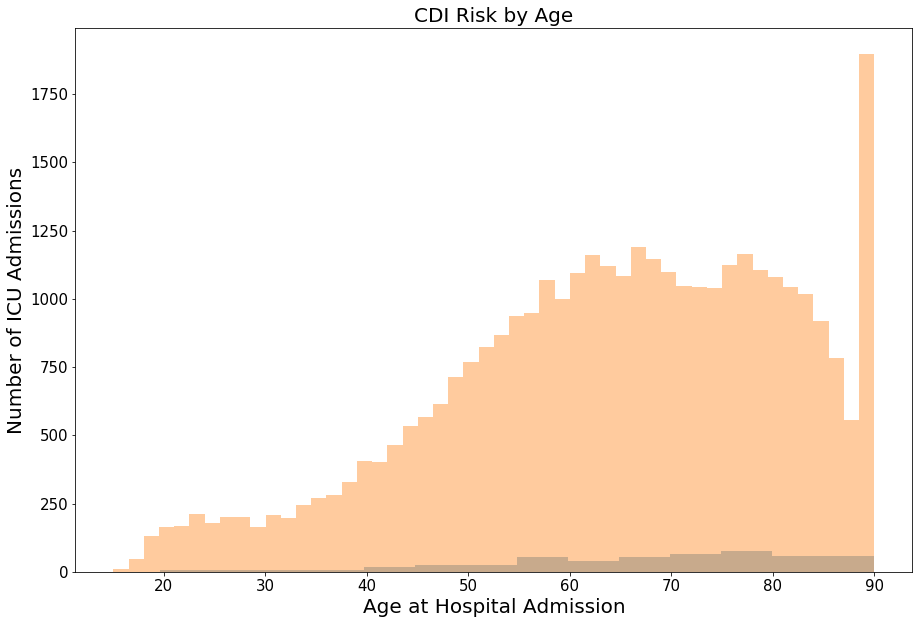

In [15]:
series1 = icu_admits_train[(icu_admits_train["overall_exclude"] == False) &
                         (icu_admits_train["cdi_lab_dx"] == 1)]["admit_age"]

series2 = icu_admits_train[(icu_admits_train["overall_exclude"] == False) &
                         (icu_admits_train["cdi_lab_dx"] == 0)]["admit_age"]

plot_two_hist(series1,
              series2,
              title = "CDI Risk by Age",
              xlabel = "Age at Hospital Admission",
              ylabel = "Number of ICU Admissions")


#### Comments:

Patients below age 19 are known to contact CDI extremely rarely and are often excluded from prediction models. I remove them here as well

In [18]:
icu_admits_train.loc[:,"overall_exclude"] = ((icu_admits_train.loc[:,"overall_exclude"] == True) | 
                                       (icu_admits_train.loc[:,"admit_age"] < 20))
icu_admits_test.loc[:,"overall_exclude"] = ((icu_admits_test.loc[:,"overall_exclude"] == True) | 
                                       (icu_admits_test.loc[:,"admit_age"] < 20))

demographics_train.loc[:,"overall_exclude"] = ((icu_admits_train.loc[:,"overall_exclude"] == True) | 
                                       (icu_admits_train.loc[:,"admit_age"] < 20))
demographics_test.loc[:,"overall_exclude"] = ((icu_admits_test.loc[:,"overall_exclude"] == True) | 
                                       (icu_admits_test.loc[:,"admit_age"] < 20))

C:\Users\fuzzyman27\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Perform univariate logistic regression on admit age to confirm statistical significance of predictor

In [19]:
uni_log("admit_age", icu_admits_train[icu_admits_train["overall_exclude"]== False], categorical = False)

Optimization terminated successfully.
         Current function value: 0.089983
         Iterations 8
Summary Stats:
                           Logit Regression Results                           
Dep. Variable:         cdi_dx_include   No. Observations:                35126
Model:                          Logit   Df Residuals:                    35125
Method:                           MLE   Df Model:                            0
Date:                Thu, 12 Sep 2019   Pseudo R-squ.:                 -0.2052
Time:                        03:46:07   Log-Likelihood:                -3160.7
converged:                       True   LL-Null:                       -2622.5
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
admit_age     -0.0694      0.001    -89.633      0.000      -0.071      -0.068
Odds Ratio
adm

Add age to demographics dataframes

In [22]:
demographics_train.loc[:,"admit age"] = icu_admits_train.loc[:,"admit_age"]
demographics_test.loc[:,"admit age"] = icu_admits_test.loc[:,"admit_age"]

C:\Users\fuzzyman27\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


##### Transform age using cubic splines
Instead of attempting to fit a linear function to age or binning them with a resulting "flat" prediction within each bin, the below proess utilizes cubic splines to enable a degree 3 polynomial function to be fit to each of several piecewise components of age.

Analysis inspired by and code derived in part from blog post here, which does a great job at explaining the value of utilizing cubic splines:

https://www.analyticsvidhya.com/blog/2018/03/introduction-regression-splines-python-codes/

Knot points are selected such that density of data is evenly distributed (35th, 50th, and 75th percentiles). As a result of these knots, 5 total age features are created

In [36]:
# Create knot points for splines based on evenly spaced percentiles of data

age_knots = np.percentile(demographics_train[(demographics_train["overall_exclude"]==False)]["admit age"], 
                           [0, 25, 50, 75])

print(age_knots)

[20.04659278 53.61864483 66.02188013 77.72439993]


In [39]:
# Use cubic spline function above to create features using above knot points and concat to demographics_df
demographics_train = pd.concat([demographics_train, 
                                create_knot_df(demographics_train, "admit age", age_knots)], axis=1)
demographics_test = pd.concat([demographics_test, 
                                create_knot_df(demographics_test, "admit age", age_knots)], axis=1)

In [42]:
result = uni_log(['admit age_knot 0', 'admit age_knot 1',
       'admit age_knot 2', 'admit age_knot 3', 'admit age_knot 4',
       'admit age_knot 5', 'admit age_knot 6'], demographics_train, categorical = False, return_model=True)

Optimization terminated successfully.
         Current function value: 0.074200
         Iterations 9
Summary Stats:
                           Logit Regression Results                           
Dep. Variable:         cdi_dx_include   No. Observations:                35126
Model:                          Logit   Df Residuals:                    35119
Method:                           MLE   Df Model:                            6
Date:                Thu, 12 Sep 2019   Pseudo R-squ.:                0.006148
Time:                        04:00:40   Log-Likelihood:                -2606.3
converged:                       True   LL-Null:                       -2622.5
Covariance Type:            nonrobust   LLR p-value:                 1.463e-05
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
admit age_knot 0    -4.5263      0.863     -5.242      0.000      -6.219      -2.

In [44]:
pred1 = result.predict(demographics_train[demographics_train["overall_exclude"]==False][['admit age_knot 0',
                                                                                       'admit age_knot 1',
                                                                                       'admit age_knot 2',
                                                                                       'admit age_knot 3', 
                                                                                       'admit age_knot 4',
                                                                                       'admit age_knot 5',
                                                                                        'admit age_knot 6']])

''

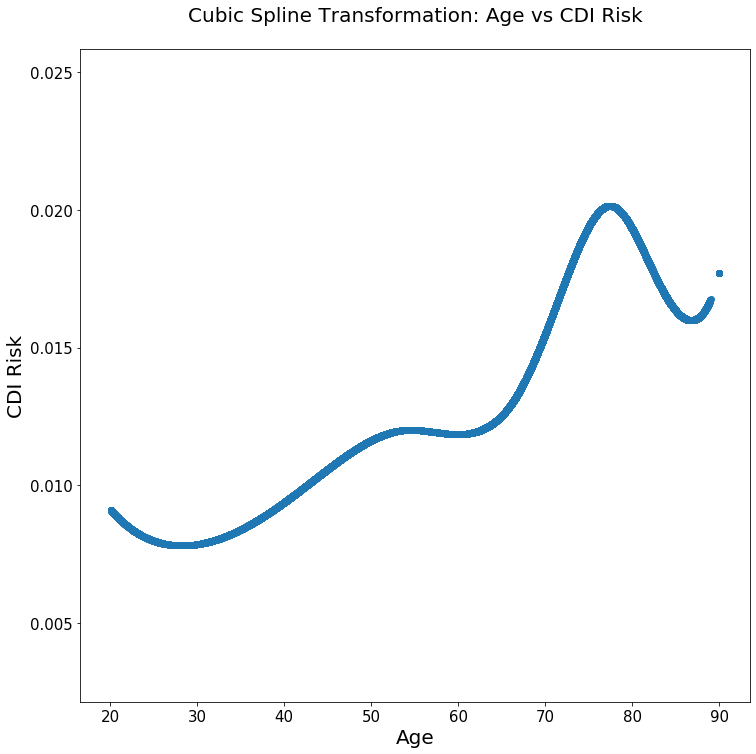

In [49]:
fig, ax = plt.subplots(figsize = (12,12))
plt.scatter(demographics_train[demographics_train["overall_exclude"]==False]["admit age"],
        pred1)
plt.title("Cubic Spline Transformation: Age vs CDI Risk\n", fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_ylabel("CDI Risk", fontsize = 20)
ax.set_xlabel("Age", fontsize = 20)  
;

##### Evaluate results

Age as the lone indepedent variable does not result in a strong model for CDI given CDI data is significantly imbalanced. However, variables achieved statistical significance both with age as a continuous variable and when transformed via cubic splines. All variables across. Once transformed, pseuod r-squared increased from -.2 to 0.001. log likelihood increased from -3160 to -2617, the latter of which is similar to the LL achieved in the null model and suggests transforming age via cubic splines is likely to improve model performance

### Gender

Note: 1 = female

##### Conduct EDA on categorical variable

In [88]:
categorical_stats("gender", icu_admits_train, binary = True)

Counts:
0    19876
1    15250
Name: gender, dtype: int64

Mean CDI Rate:
gender
0    0.013584
1    0.015082
Name: cdi_dx_include, dtype: float64

Optimization terminated successfully.
         Current function value: 0.426178
         Iterations 8
Summary Stats:
                           Logit Regression Results                           
Dep. Variable:         cdi_dx_include   No. Observations:                35126
Model:                          Logit   Df Residuals:                    35125
Method:                           MLE   Df Model:                            0
Date:                Fri, 06 Sep 2019   Pseudo R-squ.:                  -4.708
Time:                        11:56:00   Log-Likelihood:                -14970.
converged:                       True   LL-Null:                       -2622.5
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------

##### Analyze Results

Gender seems to be a weak predictor of CDI rates with mean rates of 1.5% and 1.35% between females and males respectively. Gender is a significant predictor at p << 0.05.

In [91]:
demographics_train.loc[:,"gender"] = icu_admits_train.loc[:,"gender"]
demographics_test.loc[:,"gender"] = icu_admits_test.loc[:,"gender"]

In [105]:
uni_log(['admit age_knot 0', 'admit age_knot 1',
       'admit age_knot 2', 'admit age_knot 3', 'admit age_knot 4',
       'admit age_knot 5', 'gender'], 
        demographics_train,
       categorical = False)

Optimization terminated successfully.
         Current function value: 0.074515
         Iterations 9
Summary Stats:
                           Logit Regression Results                           
Dep. Variable:         cdi_dx_include   No. Observations:                35126
Model:                          Logit   Df Residuals:                    35119
Method:                           MLE   Df Model:                            6
Date:                Fri, 06 Sep 2019   Pseudo R-squ.:                0.001925
Time:                        12:22:04   Log-Likelihood:                -2617.4
converged:                       True   LL-Null:                       -2622.5
Covariance Type:            nonrobust   LLR p-value:                    0.1206
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
admit age_knot 0    -8.7795      0.489    -17.937      0.000      -9.739      -7.

When included alongside age, gender is no longer a significant predictor and can be dropped from further analysis

In [106]:
demographics_train.drop(columns = "gender", inplace=True)
demographics_test.drop(columns = "gender", inplace=True)

### Insurance

Get categorical stats and run univariate logistic regression

In [29]:
categorical_stats("insurance", icu_admits_train, binary = False)

Counts:
Medicare      19822
Private       11051
Medicaid       2987
Government      957
Self Pay        309
Name: insurance, dtype: int64

Mean CDI Rate:
insurance
Government    0.008359
Medicaid      0.017744
Medicare      0.016446
Private       0.009954
Self Pay      0.009709
Name: cdi_dx_include, dtype: float64

Optimization terminated successfully.
         Current function value: 0.091823
         Iterations 9
Summary Stats:
                           Logit Regression Results                           
Dep. Variable:         cdi_dx_include   No. Observations:                35126
Model:                          Logit   Df Residuals:                    35122
Method:                           MLE   Df Model:                            3
Date:                Sat, 17 Aug 2019   Pseudo R-squ.:                 -0.2299
Time:                        21:38:45   Log-Likelihood:                -3225.4
converged:                       True   LL-Null:                       -2622.5
Covariance Ty

In [102]:
demographics_train = pd.concat([demographics_train,
                                pd.get_dummies(icu_admits_train["insurance"], 
                                               prefix = "insurance").drop(columns = "insurance_Medicare")],
                               axis=1)
demographics_test = pd.concat([demographics_test,
                                pd.get_dummies(icu_admits_test["insurance"], 
                                               prefix = "insurance").drop(columns = "insurance_Medicare")],
                               axis=1)

In [103]:
demographics_train.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'overall_exclude',
       'cdi_dx_include', 'admit age', 'admit age_knot 0', 'admit age_knot 1',
       'admit age_knot 2', 'admit age_knot 3', 'admit age_knot 4',
       'admit age_knot 5', 'gender', 'insurance_Government',
       'insurance_Medicaid', 'insurance_Private', 'insurance_Self Pay'],
      dtype='object')

##### Comments:
Medicare patients make up the majority of admissions and not surprisingly have higher rates of CDI, likely because of the older age of these patients.

As a sole predictor, insurance features are all statistically significant. However, these need to be validated alongside age

There are under 500 self pay patients and less than 1,000 government patients, so these should be combined with the nearest similar category (private insurance).

Before recategorizing, analysis below to determine if insurance status predictors are significant after accounting for age.

In [107]:
uni_log(['admit age_knot 0', 'admit age_knot 1',
       'admit age_knot 2', 'admit age_knot 3', 'admit age_knot 4',
       'admit age_knot 5','insurance_Government',
       'insurance_Medicaid', 'insurance_Private', 'insurance_Self Pay'], 
        demographics_train,
       categorical = False)

Optimization terminated successfully.
         Current function value: 0.074289
         Iterations 9
Summary Stats:
                           Logit Regression Results                           
Dep. Variable:         cdi_dx_include   No. Observations:                35126
Model:                          Logit   Df Residuals:                    35116
Method:                           MLE   Df Model:                            9
Date:                Fri, 06 Sep 2019   Pseudo R-squ.:                0.004950
Time:                        12:23:40   Log-Likelihood:                -2609.5
converged:                       True   LL-Null:                       -2622.5
Covariance Type:            nonrobust   LLR p-value:                  0.002074
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
admit age_knot 0        -8.4681      0.532    -15.932      0.000      -9.

##### Comments:

The only significant feature at p < .05 is private insurance. Self pay and government, though similar in odds ratios to private insurance are not significant, likely due to the smaller sample size. Below analysis repeated with self pay and government rolled up into private insurance

In [109]:
demographics_train["insurance_govt_self_private"] = ((demographics_train["insurance_Private"] == 1) |
                                                     (demographics_train["insurance_Self Pay"] == 1) |
                                                     (demographics_train["insurance_Government"] == 1)).map(lambda x: 1 if x == True else 0)
demographics_test["insurance_govt_self_private"] = ((demographics_test["insurance_Private"] == 1) |
                                                     (demographics_test["insurance_Self Pay"] == 1) |
                                                     (demographics_test["insurance_Government"] == 1)).map(lambda x: 1 if x == True else 0)

In [110]:
uni_log(['admit age_knot 0', 'admit age_knot 1',
       'admit age_knot 2', 'admit age_knot 3', 'admit age_knot 4',
       'admit age_knot 5', "insurance_govt_self_private"], 
        demographics_train,
       categorical = False)

Optimization terminated successfully.
         Current function value: 0.074331
         Iterations 9
Summary Stats:
                           Logit Regression Results                           
Dep. Variable:         cdi_dx_include   No. Observations:                35126
Model:                          Logit   Df Residuals:                    35119
Method:                           MLE   Df Model:                            6
Date:                Fri, 06 Sep 2019   Pseudo R-squ.:                0.004393
Time:                        12:31:06   Log-Likelihood:                -2610.9
converged:                       True   LL-Null:                       -2622.5
Covariance Type:            nonrobust   LLR p-value:                 0.0007827
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
admit age_knot 0               -8.2225      0.506    -16.26

##### Comments:

Insurance remains a significant feature when private, self pay and government are all rolled into one feature, with an almost identical max log-likelihood result compared to all insurance types modeled separately. 

In [112]:
demographics_train.drop(columns = ['insurance_Government', 'insurance_Medicaid',
       'insurance_Private', 'insurance_Self Pay'], inplace=True)

demographics_test.drop(columns = ['insurance_Government', 'insurance_Medicaid',
       'insurance_Private', 'insurance_Self Pay'], inplace=True)

###  Language

In [32]:
icu_admits_train[icu_admits_train["overall_exclude"] == False]["language"].value_counts().head(10)

ENGL    19871
None    12180
SPAN      740
RUSS      542
PTUN      413
CANT      258
PORT      238
CAPE      141
HAIT       94
ITAL       89
Name: language, dtype: int64

Given there are a wide variety of languages spoken, analysis below is for english vs all others

In [33]:
print("English: ")
print(icu_admits_train[(icu_admits_train["overall_exclude"] == False)&
                       (icu_admits_train["language"] == "ENGL")]["cdi_dx_include"].mean())

print("Spanish: ")
print(icu_admits_train[(icu_admits_train["overall_exclude"] == False)&
                       (icu_admits_train["language"] == "SPAN")]["cdi_dx_include"].mean())

print("No Language: ")
print(icu_admits_train[(icu_admits_train["overall_exclude"] == False)&
                       (icu_admits_train["language"] == "None")]["cdi_dx_include"].mean())

print("Others: ")
print(icu_admits_train[(icu_admits_train["overall_exclude"] == False)&
                       (icu_admits_train["language"] != "ENGL")&
                       (icu_admits_train["language"] != "SPAN") &
                       (icu_admits_train["language"] != "None")]["cdi_dx_include"].mean())

English: 
0.012782446781742238
Spanish: 
0.016216216216216217
No Language: 
0.015763546798029555
Others: 
0.017987152034261242


##### Comments:
English patients seem to have lower CDI rates compared to patients who speak other languages while those who speak "other" languages seem to have slightly higher CDI rates. Statistical validation done below by creating dummy variables for these lanugages and modeling with logistic regression

In [116]:
demographics_train.loc[:,"lang_english"] = (icu_admits_train.loc[:,"language"] == "ENGL").map(lambda x: 1 if x == True else 0)
demographics_test.loc[:,"lang_english"] = (icu_admits_test.loc[:,"language"] == "ENGL").map(lambda x: 1 if x == True else 0)

demographics_train.loc[:,"lang_spanish"] = (icu_admits_train.loc[:,"language"] == "SPAN").map(lambda x: 1 if x == True else 0)
demographics_test.loc[:,"lang_spanish"] = (icu_admits_test.loc[:,"language"] == "SPAN").map(lambda x: 1 if x == True else 0)

demographics_train.loc[:,"lang_None"] = (icu_admits_train.loc[:,"language"] == "None").map(lambda x: 1 if x == True else 0)
demographics_test.loc[:,"lang_None"] = (icu_admits_test.loc[:,"language"] == "None").map(lambda x: 1 if x == True else 0)


In [117]:
demographics_train.loc[:,"lang_Other"] = ((demographics_train.loc[:,"lang_english"] == 0)&
                                         (demographics_train.loc[:,"lang_spanish"] == 0)&
                                         (demographics_train.loc[:,"lang_None"] == 0)).map(lambda x: 1 if x == True else 0)

demographics_test.loc[:,"lang_Other"] = ((demographics_test.loc[:,"lang_english"] == 0)&
                                         (demographics_test.loc[:,"lang_spanish"] == 0)&
                                         (demographics_test.loc[:,"lang_None"] == 0)).map(lambda x: 1 if x == True else 0)

In [126]:
demographics_train.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'overall_exclude',
       'cdi_dx_include', 'admit age', 'admit age_knot 0', 'admit age_knot 1',
       'admit age_knot 2', 'admit age_knot 3', 'admit age_knot 4',
       'admit age_knot 5', 'insurance_govt_self_private', 'lang_english',
       'lang_spanish', 'lang_None', 'lang_Other'],
      dtype='object')

In [127]:
uni_log(['lang_english',
       'lang_spanish', 'lang_Other'], demographics_train, categorical = False)

Optimization terminated successfully.
         Current function value: 0.286796
         Iterations 8
Summary Stats:
                           Logit Regression Results                           
Dep. Variable:         cdi_dx_include   No. Observations:                35126
Model:                          Logit   Df Residuals:                    35123
Method:                           MLE   Df Model:                            2
Date:                Fri, 06 Sep 2019   Pseudo R-squ.:                  -2.841
Time:                        13:29:49   Log-Likelihood:                -10074.
converged:                       True   LL-Null:                       -2622.5
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
lang_english    -4.3468      0.063    -68.833      0.000      -4.471      -4.223
lang_spa

All three language variables are significant predictors at p < .05 when compared to a base value of language = "None"

In [128]:
uni_log(['admit age_knot 0', 'admit age_knot 1',
       'admit age_knot 2', 'admit age_knot 3', 'admit age_knot 4',
       'admit age_knot 5', 'insurance_govt_self_private', 'lang_english',
       'lang_spanish', 'lang_Other'],
       demographics_train,
       categorical=False)

Optimization terminated successfully.
         Current function value: 0.074233
         Iterations 9
Summary Stats:
                           Logit Regression Results                           
Dep. Variable:         cdi_dx_include   No. Observations:                35126
Model:                          Logit   Df Residuals:                    35116
Method:                           MLE   Df Model:                            9
Date:                Fri, 06 Sep 2019   Pseudo R-squ.:                0.005710
Time:                        13:30:57   Log-Likelihood:                -2607.5
converged:                       True   LL-Null:                       -2622.5
Covariance Type:            nonrobust   LLR p-value:                 0.0004478
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
admit age_knot 0               -7.9740      0.520    -15.34

After accounting for age and insurance, english is the only remaining significant predictor

In [129]:
demographics_train.drop(columns = ['lang_spanish', 'lang_Other', "lang_None"], inplace=True)
demographics_test.drop(columns = ['lang_spanish', 'lang_Other', "lang_None"], inplace=True)

### Ethnicity

In [56]:
icu_admits_train[icu_admits_train["overall_exclude"] == False]["first_ethnicity"].value_counts()

WHITE                                                       25087
BLACK/AFRICAN AMERICAN                                       3144
UNKNOWN/NOT SPECIFIED                                        2796
HISPANIC OR LATINO                                            908
ASIAN                                                         843
OTHER                                                         807
UNABLE TO OBTAIN                                              547
PATIENT DECLINED TO ANSWER                                    305
HISPANIC/LATINO                                               292
BLACK/CAPE VERDEAN                                            103
MULTI RACE ETHNICITY                                           68
BLACK/HAITIAN                                                  64
PORTUGUESE                                                     56
BLACK/AFRICAN                                                  30
MIDDLE EASTERN                                                 30
AMERICAN I

Similar to language, there are a wide variety of values here. Analysis of CDI rates below is done by grouping categories above together for whites, african americans, hispanic/latino and others.

In [36]:
print("White: ")
print(icu_admits_train[icu_admits_train["first_ethnicity"] == "WHITE"]["cdi_dx_include"].mean())

print("Black / African American: ")
print(icu_admits_train[(icu_admits_train["first_ethnicity"] == "BLACK/AFRICAN AMERICAN") |
                      (icu_admits_train["first_ethnicity"] == "BLACK/CAPE VERDEAN")|
                      (icu_admits_train["first_ethnicity"] == "BLACK/HAITIAN")|
                      (icu_admits_train["first_ethnicity"] == "BLACK/AFRICAN")]["cdi_dx_include"].mean())

print("Hispanic or Latino: ")
print(icu_admits_train[(icu_admits_train["first_ethnicity"] == "HISPANIC OR LATNO")|
                       (icu_admits_train["first_ethnicity"] == "HISPANIC/LATINO")|
                      (icu_admits_train["first_ethnicity"] == "SOUTH AMERICAN")]["cdi_dx_include"].mean())

print("Unknown and Others: ")
print(icu_admits_train[(icu_admits_train["first_ethnicity"] != "WHITE")&
                       (icu_admits_train["first_ethnicity"] != "BLACK/AFRICAN AMERICAN")&
                       (icu_admits_train["first_ethnicity"] != "BLACK/CAPE VERDEAN")&
                       (icu_admits_train["first_ethnicity"] != "BLACK/HAITIAN")&
                       (icu_admits_train["first_ethnicity"] != "BLACK/AFRICAN")&
                       (icu_admits_train["first_ethnicity"] != "HISPANIC OR LATNO")&
                       (icu_admits_train["first_ethnicity"] != "HISPANIC/LATINO") &
                       (icu_admits_train["first_ethnicity"] != "SOUTH AMERICAN")]["cdi_dx_include"].mean())

White: 
0.013463032141139919
Black / African American: 
0.013623978201634877
Hispanic or Latino: 
0.015479876160990712
Unknown and Others: 
0.012177012177012177


The two most common ethnicities presenting to the ICU, white and african americans, don't show a major difference in CDI rates. While others show slight deviations, the sample of patients in these categories is much smaller and less likely to be meaningful.

In [138]:
demographics_train["first_ethnicity_white"] = (icu_admits_train["first_ethnicity"] == "WHITE").map(lambda x: 1 if x == True else 0)
demographics_train["first_ethnicity_black"] = ((icu_admits_train["first_ethnicity"] == "BLACK/AFRICAN AMERICAN") |
                                             (icu_admits_train["first_ethnicity"] == "BLACK/CAPE VERDEAN")|
                                             (icu_admits_train["first_ethnicity"] == "BLACK/HAITIAN")|
                                             (icu_admits_train["first_ethnicity"] == "BLACK/AFRICAN")).map(lambda x: 1 if x == True else 0)
demographics_train["first_ethnicity_hisp_latino"] = ((icu_admits_train["first_ethnicity"] == "HISPANIC OR LATNO")|
                                                   (icu_admits_train["first_ethnicity"] == "HISPANIC/LATINO")|
                                                   (icu_admits_train["first_ethnicity"] == "SOUTH AMERICAN")).map(lambda x: 1 if x == True else 0)

demographics_test["first_ethnicity_white"] = (icu_admits_test["first_ethnicity"] == "WHITE").map(lambda x: 1 if x == True else 0)
demographics_test["first_ethnicity_black"] = ((icu_admits_test["first_ethnicity"] == "BLACK/AFRICAN AMERICAN") |
                                             (icu_admits_test["first_ethnicity"] == "BLACK/CAPE VERDEAN")|
                                             (icu_admits_test["first_ethnicity"] == "BLACK/HAITIAN")|
                                             (icu_admits_test["first_ethnicity"] == "BLACK/AFRICAN")).map(lambda x: 1 if x == True else 0)
demographics_test["first_ethnicity_hisp_latino"] = ((icu_admits_test["first_ethnicity"] == "HISPANIC OR LATNO")|
                                                   (icu_admits_test["first_ethnicity"] == "HISPANIC/LATINO")|
                                                   (icu_admits_test["first_ethnicity"] == "SOUTH AMERICAN")).map(lambda x: 1 if x == True else 0)

In [140]:
demographics_train.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'overall_exclude',
       'cdi_dx_include', 'admit age', 'admit age_knot 0', 'admit age_knot 1',
       'admit age_knot 2', 'admit age_knot 3', 'admit age_knot 4',
       'admit age_knot 5', 'insurance_govt_self_private', 'lang_english',
       'first_ethnicity_white', 'first_ethnicity_black',
       'first_ethnicity_hisp_latino'],
      dtype='object')

In [141]:
uni_log(['admit age_knot 0', 'admit age_knot 1',
       'admit age_knot 2', 'admit age_knot 3', 'admit age_knot 4',
       'admit age_knot 5', 'insurance_govt_self_private', 'lang_english',
       'first_ethnicity_white', 'first_ethnicity_black',
       'first_ethnicity_hisp_latino'],
        demographics_train,
        categorical=False)

Optimization terminated successfully.
         Current function value: 0.074214
         Iterations 9
Summary Stats:
                           Logit Regression Results                           
Dep. Variable:         cdi_dx_include   No. Observations:                35126
Model:                          Logit   Df Residuals:                    35115
Method:                           MLE   Df Model:                           10
Date:                Fri, 06 Sep 2019   Pseudo R-squ.:                0.005963
Time:                        13:52:56   Log-Likelihood:                -2606.8
converged:                       True   LL-Null:                       -2622.5
Covariance Type:            nonrobust   LLR p-value:                 0.0005286
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
admit age_knot 0               -8.1414      0.539    -15.09

##### Comments:

None of the 3 ethnicity groups are significant predictors once accounting for age, insurance and english language

In [142]:
demographics_train.drop(columns = ['first_ethnicity_white', 'first_ethnicity_black',
       'first_ethnicity_hisp_latino'],inplace=True)
demographics_test.drop(columns = ['first_ethnicity_white', 'first_ethnicity_black',
       'first_ethnicity_hisp_latino'],inplace=True)

### Marital Status

In [143]:
categorical_stats("marital_status", icu_admits_train, binary=False, skip_model=True)

Counts:
MARRIED              17067
SINGLE                8639
WIDOWED               5009
DIVORCED              2303
None                  1445
SEPARATED              412
UNKNOWN (DEFAULT)      239
LIFE PARTNER            12
Name: marital_status, dtype: int64

Mean CDI Rate:
marital_status
DIVORCED             0.007816
LIFE PARTNER         0.000000
MARRIED              0.013769
None                 0.016609
SEPARATED            0.012136
SINGLE               0.014238
UNKNOWN (DEFAULT)    0.029289
WIDOWED              0.017568
Name: cdi_dx_include, dtype: float64



Separated, unknown and life partner marital status all have < 500 observations and none have over 10 CDI cases. Recoding done below before further analysis. Recoding based on marital statuses that are most similar:

Life partner recoded as "married"
"separated" recoded to "married" instead of "divorced" based on closer average CDI rates,
"Unknown" recoded to none based on similarity of description 

In [164]:
# demographics_train['marital_status'] = 
demographics_train.loc[:,"marital_status_recode"] = icu_admits_train.loc[:,"marital_status"].map({"UNKNOWN (DEFAULT)" : "None",
                                                                                      "None" : "None",
                                                                                      "LIFE PARTNER" : "MARRIED",
                                                                                     "MARRIED" : "MARRIED",
                                                                                     "SINGLE" : "SINGLE",
                                                                                     "WIDOWED" : "WIDOWED",
                                                                                     "DIVORCED" : "DIVORCED",
                                                                                     "SEPARATED" : "SEPARATED"})
demographics_test.loc[:,"marital_status_recode"] = icu_admits_test.loc[:,"marital_status"].map({"UNKNOWN (DEFAULT)" : "None",
                                                                                      "None" : "None",
                                                                                      "LIFE PARTNER" : "MARRIED",
                                                                                     "MARRIED" : "MARRIED",
                                                                                     "SINGLE" : "SINGLE",
                                                                                     "WIDOWED" : "WIDOWED",
                                                                                     "DIVORCED" : "DIVORCED",
                                                                                     "SEPARATED" : "SEPARATED"})

In [165]:
demographics_train = pd.concat([demographics_train,
                                pd.get_dummies(demographics_train["marital_status_recode"], 
                                               prefix = "marital_status").drop(columns = "marital_status_MARRIED")],
                               axis=1)

demographics_test = pd.concat([demographics_test,
                                pd.get_dummies(demographics_test["marital_status_recode"], 
                                               prefix = "marital_status").drop(columns = "marital_status_MARRIED")],
                               axis=1)

In [166]:
demographics_train.drop(columns = "marital_status_recode", inplace=True)
demographics_test.drop(columns = "marital_status_recode", inplace=True)

In [167]:
demographics_train.columns

Index(['Unnamed: 0', 'subject_id', 'hadm_id', 'icustay_id', 'overall_exclude',
       'cdi_dx_include', 'admit age', 'admit age_knot 0', 'admit age_knot 1',
       'admit age_knot 2', 'admit age_knot 3', 'admit age_knot 4',
       'admit age_knot 5', 'insurance_govt_self_private', 'lang_english',
       'marital_status_DIVORCED', 'marital_status_None',
       'marital_status_SEPARATED', 'marital_status_SINGLE',
       'marital_status_WIDOWED'],
      dtype='object')

In [168]:
uni_log(['admit age_knot 0', 'admit age_knot 1',
       'admit age_knot 2', 'admit age_knot 3', 'admit age_knot 4',
       'admit age_knot 5', 'insurance_govt_self_private', 'lang_english',
       'marital_status_DIVORCED', 'marital_status_None',
       'marital_status_SEPARATED', 'marital_status_SINGLE',
       'marital_status_WIDOWED'], demographics_train, categorical=False)

Optimization terminated successfully.
         Current function value: 0.074100
         Iterations 9
Summary Stats:
                           Logit Regression Results                           
Dep. Variable:         cdi_dx_include   No. Observations:                35126
Model:                          Logit   Df Residuals:                    35113
Method:                           MLE   Df Model:                           12
Date:                Fri, 06 Sep 2019   Pseudo R-squ.:                0.007487
Time:                        14:10:32   Log-Likelihood:                -2602.8
converged:                       True   LL-Null:                       -2622.5
Covariance Type:            nonrobust   LLR p-value:                 9.493e-05
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
admit age_knot 0               -8.1119      0.560    -14.49

#### Comments:

Divorced is the only significant marital status predictor after age, insurance and language has been taken into account

In [169]:
demographics_train.drop(columns = ['marital_status_None',
       'marital_status_SEPARATED', 'marital_status_SINGLE',
       'marital_status_WIDOWED'], inplace=True)
demographics_test.drop(columns = ['marital_status_None',
       'marital_status_SEPARATED', 'marital_status_SINGLE',
       'marital_status_WIDOWED'], inplace=True)

## Export adjusted icu admits and demographic features dfs

In [6]:
# Drop age column from features (only sublic spline transformed features remain)
demographics_train.drop(columns = ["admit age"],inplace=True)
demographics_test.drop(columns = ["admit age"],inplace=True)

In [7]:
icu_admits_train.to_csv("../Data/3 - ICU Admits Train.csv")
icu_admits_test.to_csv("../Data/3 - ICU Admits Test.csv")
demographics_train.to_csv("../Data/3 - Demographics Train.csv", index=False)
demographics_test.to_csv("../Data/3 - Demographics Test.csv", index=False)

In [4]:
# Code to read in exported dataframes above to make modifications without re-running all code above
demographics_train = pd.read_csv("../Data/3 - Demographics Train.csv")
demographics_test = pd.read_csv("../Data/3 - Demographics Test.csv")